# Part C

I. load data

In [2]:
read_data <- function(fname) 
{
   data <- read.csv(file=fname,head=TRUE,sep=",")
   return (data)
}

train_data = read_data('./Task2C_train.csv')
test_data = read_data('./Task2C_test.csv')

train_data = train_data[which(!is.na(train_data$x1)),]
test_data = test_data[which(!is.na(test_data$x1)),]

# indexs = sample(1:dim(train_data)[1], size=200, replace = F)
# train_data = train_data[indexs,]

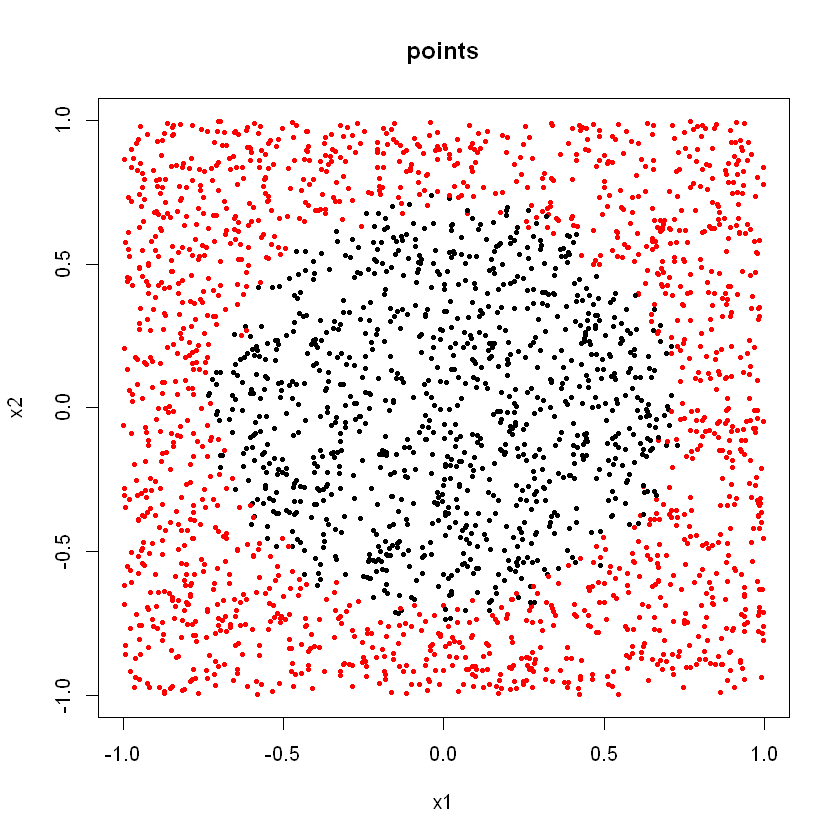

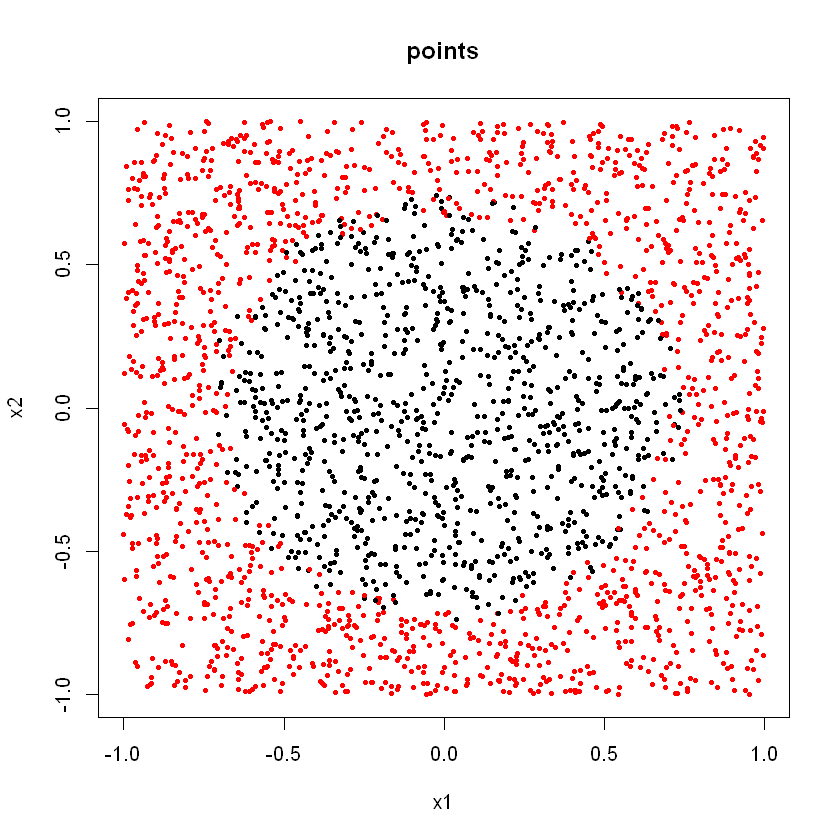

In [3]:
plot(train_data$x1, train_data$x2, col=adjustcolor(train_data$y+1, alpha=1), pch=16, main='points', xlab = 'x1', ylab = 'x2', cex = 0.5)
plot(test_data$x1, test_data$x2, col=adjustcolor(test_data$y+1, alpha=1), pch=16, main='points', xlab = 'x1', ylab = 'x2', cex = 0.5)

II. perceptron

In [4]:
X1 <- data.matrix(train_data[,1:2])
T1 <- data.matrix(as.numeric(train_data[,3]))

X2 <- data.matrix(test_data[,1:2])
T2 <- data.matrix(as.numeric(test_data[,3]))

In [5]:
# auxiliary function to calculate labels based on the estimated coefficients
predict_func <- function(Phi, w)
{
    return(Phi%*%w)
} 

# auxiliary function to calculate a cost function
error_func <- function (Phi, w, label, lambda)
{
    return(mean((predict_func(Phi, w) - label)^2)/2)
#     return(sum((predict_func(Phi, w) - label)^2)/2)
}

In [7]:
perceptron_train <- function(train.data, train.label, test.data, test.label, eta)
{
#     set.seed(123)
    train.len = nrow(train.data)
    # project data using a basis function (identical here)
    Phi <- as.matrix(cbind('X0'= 1, train.data)) # add a column of 1 as phi_0
    T <- as.numeric(train.label)# rename just for conviniance
    test_Phi <- as.matrix(cbind(1, test.data)) # add a column of 1 as phi_0
    test_T <- as.numeric(test.label)

    
    tau.max <- 20 # maximum number of iterations
    epsilon <- 0.1 * mean(T) # a threshold on the cost (to terminate the process)
    lambda = 0.01
    W <- matrix(,nrow=tau.max, ncol=ncol(Phi)) # be used to store the estimated oefficients
    set.seed(12)
    W[1,] <- runif(ncol(Phi)) # initial weight (any better idea?)
    W[1,] 
    error <- data.frame('tau'=1:tau.max)  # to be used to trace the test and training errors in each iteration
    tau <- 1 # iteration counter
    terminate <- FALSE

    while(!terminate)
    {
        # check termination criteria:
        if (terminate <- tau >= tau.max | error_func(Phi, W[tau,], T, lambda) <= epsilon) {terminate<-TRUE;break}

        # shuffle data:
        train.index <- sample(1:train.len, train.len, replace = FALSE)
        Phi <- Phi[train.index,]
        T <- T[train.index]
        # for each datapoint:
        for (i in 1:train.len){

            if (tau >= tau.max | error_func(Phi, W[tau,], T, lambda)<= epsilon) {terminate<-TRUE;break}
            t_pred = predict_func(Phi[i,], W[tau,])
            # for each coefficient:
            for (j in 1: ncol(W)){
                # update the coefficient:
                grad <- (T[i]-t_pred) * Phi[i,j] - lambda * W[tau,j]
                W[(tau+1),j] <- W[tau,j] + eta * grad

            }

            # record the error:
            error[tau, 'train'] <- error_func(as.matrix(Phi), W[tau,],T, lambda)
            error[tau, 'test'] <- error_func(as.matrix(test_Phi), W[tau,],test_T, lambda)

            # update the counter:
            tau <- tau + 1        
        }

    }
    col = predict_func(as.matrix(test_Phi), W[tau,])
    for(i in 1:length(col))
    {
        if(col[i] > 0.5)
        {
            col[i] = 1
        }
        else
        {
            col[i] = 0
        }
    }
    plot(test_Phi[,2],test_Phi[,3], col=adjustcolor(col+1, alpha=1), pch=16, main=paste("predict points with eta =" , as.character(eta)) , xlab = 'x1', ylab = 'x2', cex = 0.5)
    return(error[tau-1, 'test']) 
}

[1] 0.4389704

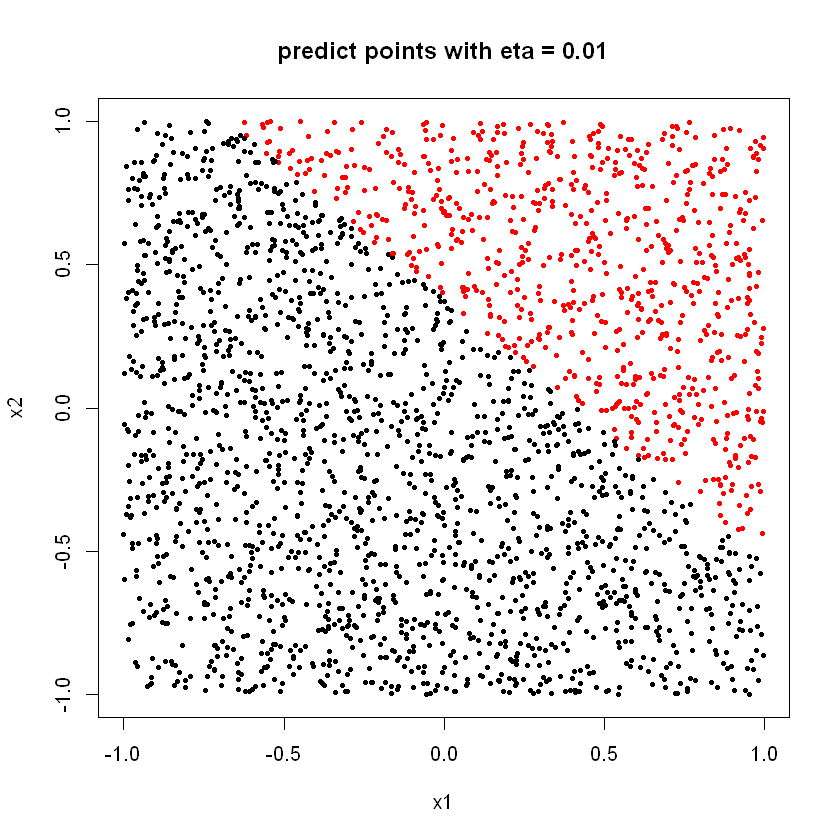

In [8]:
perceptron_train(X1, T1, X2, T2, 0.01)

[1] 0.1889172

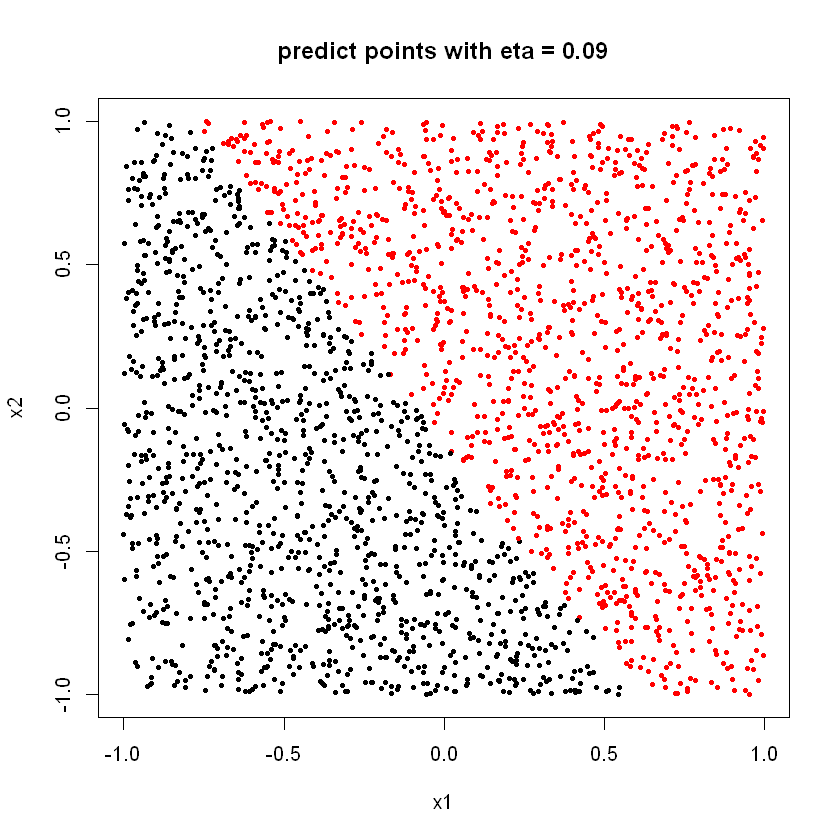

In [9]:
perceptron_train(X1, T1, X2, T2, 0.09)

III neural network

In [10]:
# auxiliary functions 
## the activation function (sigmoid here)
h <- function(z, a=1) { 
  return ((exp(z)-a^(-z))/(exp(z)+exp(-z)))
}
## the derivitive of the activation function 
h.d <- function(z, a=1) {
  return (1-(h(z, a))^2)
}
relu <- function(z) {   
    z = z + abs(z) 
    return (z/2)
}
## the derivitive of the activation function (sigmoid here)
relu.d <- function(z) {
    for(i in 1:dim(z)[1])
    {
        for(j in 1:dim(z)[2])
        {
            if(z[i,j] > 0)
            {
                z[i,j] = 1
            }
            else
            {
                z[i,j] = 0
            }
        }
    }
    return (z)
}
## Class Probabilities
probability <- function(X, W1, W2, b1, b2){
    a2 <- h(sweep(W1 %*% X, 1, b1,'+' ))
    a3 <- h(sweep(W2 %*% a2, 1, b2,'+' ))
    return (a3)
}

## prediction
prediction <- function(X, W1, W2, b1, b2, threshold=0){
    return (ifelse(probability(X, W1, W2, b1, b2)>=threshold, 1, -1))
}
## Accuracy
accuracy <- function(Y, T){
    return (sum(Y==T)/length(T)*100)
}
## The following structure helps us to have functions with multiple outputs
### credit: https://stat.ethz.ch/pipermail/r-help/2004-June/053343.html
list <- structure(NA,class="result")
"[<-.result" <- function(x,...,value) {
   args <- as.list(match.call())
   args <- args[-c(1:2,length(args))]
   length(value) <- length(args)
   for(i in seq(along=args)) {
     a <- args[[i]]
     if(!missing(a)) eval.parent(substitute(a <- v,list(a=a,v=value[[i]])))
   }
   x
}

In [11]:
feedforward <- function(Xi, Ti, W1, b1, W2, b2){
  ### 1st (input) layer 
  a1 <- Xi
  y <- Ti
  ### 2nd (hidden) layer
  z2 <- W1 %*% a1 + b1
  a2 <- relu(z2)        
  ### 3rd (output) layer
  z3 <- W2 %*% a2 + b2
  a3 <- h(z3)  
  return(list(a1, a2, a3, y, z2, z3))
}
## backpropagation step
backpropagation <- function(Ti, W2, z2, z3, a3){
  ### 3rd (output) layer
  d3 <- -(Ti-a3) * h.d(z3)
  ### 2nd (hidden) layer
  d2 <-  t(W2)%*%d3  * relu.d (z2)
  return(list(d2,d3))
}

In [12]:
loss <- function(test.label, test.output)
{
    test.label <- as.numeric(test.label)
    test.output <- as.numeric(test.output)
    error = 0
    for (i in 1:length(test.label))
    {

        error = error + (test.label[i] - test.output[i]) * (test.label[i] - test.output[i]) / 2
    }
#         error = error + abs(test.label[i] - test.output[i])
    return(error / length(test.label))
}

In [13]:
X1 <- t(data.matrix(train_data[,1:2]))
T1 <- t(data.matrix(as.numeric(train_data[,3]))) 
for(i in 1:length(T1))
{
    if(T1[i] == 0)
    {
        T1[i] = -1
    }
}

X2 <- t(data.matrix(test_data[,1:2]))
T2 <- t(data.matrix(as.numeric(test_data[,3]))) 
for(i in 1:length(T2))
{
    if(T2[i] == 0)
    {
        T2[i] = -1
    }
}


In [35]:
nn <- function(K, eta)
{
    N <- length(T1) # total number of samples
    D <- 2 # number of dimensions
    epoch.max <- 3000 # maximum number of iterations
    lambda <- 0.01 # regularization term
    # initialization
    epoch <- 1 # epoch (iteration) counter
    terminate <- FALSE   # termination criteria

    W1 <- matrix(rnorm(D*K, sd=0.5), nrow=K, ncol=D)
    b1 <- matrix(rnorm(1*K), nrow=K, ncol=1)
    W2 <- matrix(rnorm(K*1, sd=0.5), nrow=1, ncol=K)
    b2 <- matrix(rnorm(1*1), nrow=1, ncol=1)


    while (!terminate){
    
        ## delta vectors/matrices initialization (for batch backpropagation)
        ### .d stands for delta
        
        ## delta vectors/matrices initialization
        W1.d <- W1 *0
        b1.d <- b1 *0
        W2.d <- W2 *0
        b2.d <- b2 *0
        
        for (i in 1:N){
        ## Feedforward:
        list[a1, a2, a3, y, z2, z3] <- feedforward(X1[,i], T1[i], W1, b1, W2, b2)          
        ## Backpropagation:
        list[d2, d3] <- backpropagation(T1[i], W2, z2, z3, a3)
        ## calculate the delta values
        ### 1st layer
        W1.d <- W1.d + d2 %*% t(a1)
        b1.d <- b1.d + d2
        ### 2nd layer
        W2.d <- W2.d + d3 %*% t(a2)
        b2.d <- b2.d + d3
        }
        ## update weight vectors and matrices
        W1 <- W1 - eta * (W1.d/N + lambda*W1)
        b1 <- b1 - eta * (b1.d/N)
        W2 <- W2 - eta * (W2.d/N + lambda*W2)
        b2 <- b2 - eta * (b2.d/N)
        
        ## increase the iteration counter
        epoch <- epoch + 1
        
        ## check the termination criteria
        if (epoch > epoch.max) {terminate <- TRUE}
    }

    return(list(W1, W2, b1, b2))
}

In [37]:
list[W1, W2, b1, b2] = nn(100, 0.09)

ERROR: Error in if (z[i, j] > 0) {: 需要TRUE/FALSE值的地方不可以用缺少值


In [ ]:
accuracy(prediction(X1, W1, W2, b1, b2), T1)
accuracy(prediction(X2, W1, W2, b1, b2), T2)
loss(probability(X2, W1, W2, b1, b2), T2)

[1] 52.68

[1] 50.6

[1] 0.4520953

In [216]:
training.result <- data.frame(k=seq(5,100,5),W1=NA*20,W2=NA*20,b1=NA*20,b2=NA*20,error=NA*20)

for (k in seq(5,100,5)) {
  
  # record model parameters  
  list[W1, W2, b1, b2]<- nn(k, eta = 0.09)
  
  #Record the test errors for plotting purposes (TO BE COMPLETE) 
  training.result[training.result$k==k,2][[1]] <- list(W1)
  training.result[training.result$k==k,3][[1]] <- list(W2)
  training.result[training.result$k==k,4][[1]] <- list(b1)
  training.result[training.result$k==k,5][[1]] <- list(b2)
  training.result[training.result$k==k,6] <- loss(probability(X2, W1, W2, b1, b2), T2)
    
}
print('done')

[1] "done"


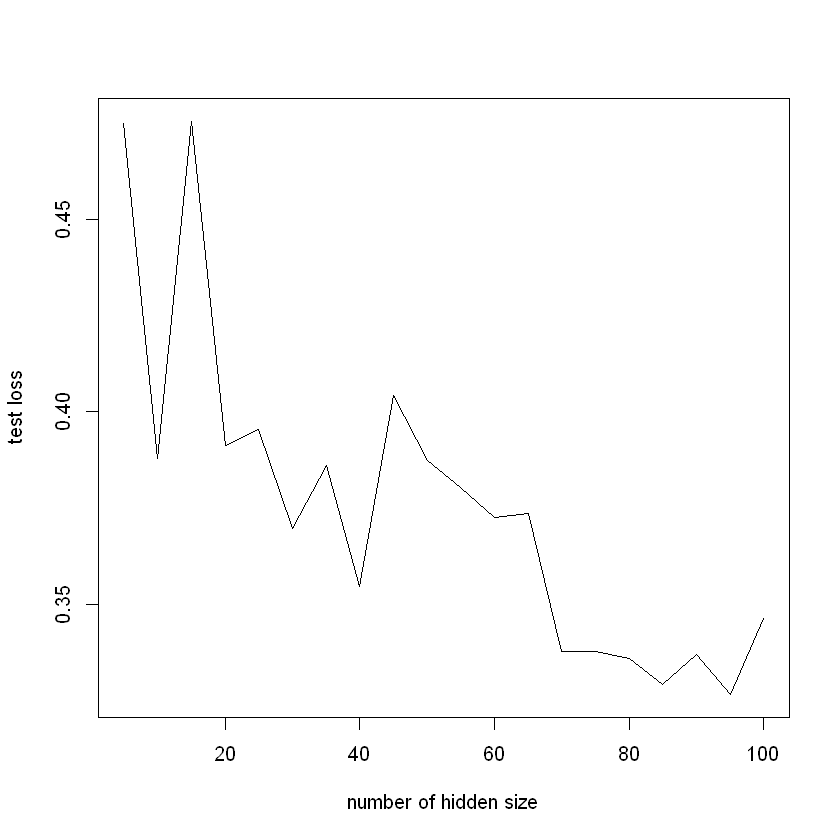

In [217]:
plot(training.result$k,training.result$error, type = 'l',ylab = 'test loss', xlab = 'number of hidden size', main = 'test loss vs hidden size with eta = 0.09')

In [237]:
k = which.min(training.result$error) * 5
print(k)

[1] 95


In [238]:
W1= training.result[training.result$k==k,2][[1]] 
W2 = training.result[training.result$k==k,3][[1]] 
b1 = training.result[training.result$k==k,4][[1]] 
b2 = training.result[training.result$k==k,5][[1]] 

In [31]:
accuracy(prediction(X1, W1, W2, b1, b2), T1)
accuracy(prediction(X2, W1, W2, b1, b2), T2)

[1] 52.68

[1] 50.6

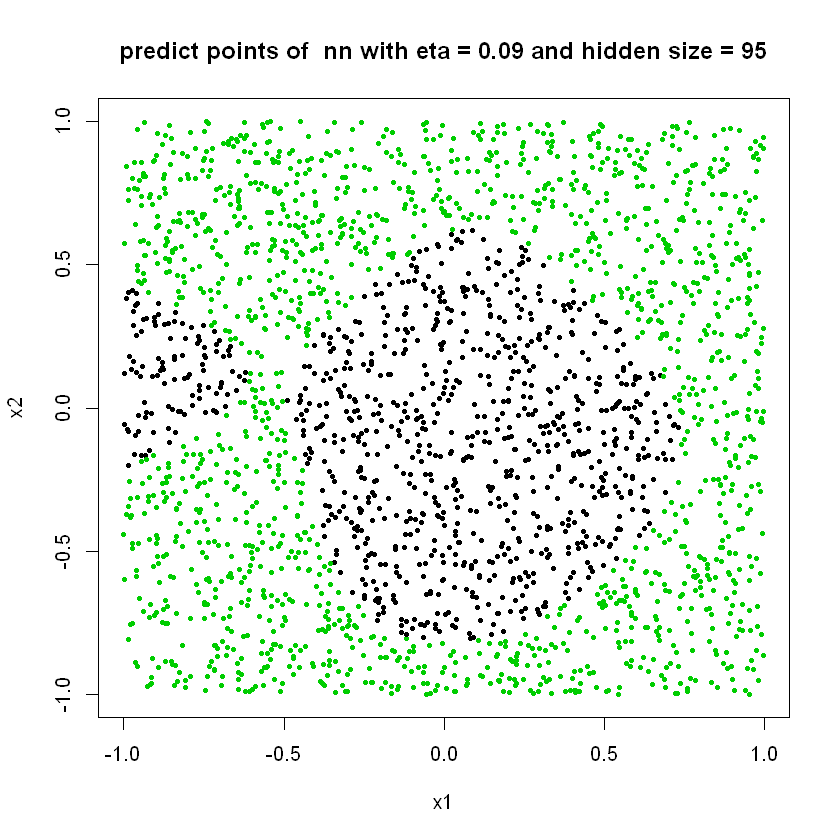

In [240]:
plot(X2[1,], X2[2,], col=adjustcolor(prediction(X2, W1, W2, b1, b2)+2, alpha=1),  pch=16, 
                    main=paste('predict points of  nn with eta = 0.09 and hidden size =', as.character(k)), 
                    xlab = 'x1', ylab = 'x2', cex = 0.5)

In [221]:
training.result_ <- data.frame(k=seq(5,100,5),W1=NA*20,W2=NA*20,b1=NA*20,b2=NA*20,error=NA*20)

for (k in seq(5,100,5)) {
  
  # record model parameters  
  list[W1, W2, b1, b2]<- nn(k, eta = 0.01)
  
  #Record the test errors for plotting purposes (TO BE COMPLETE) 
  training.result_[training.result_$k==k,2][[1]] <- list(W1)
  training.result_[training.result_$k==k,3][[1]] <- list(W2)
  training.result_[training.result_$k==k,4][[1]] <- list(b1)
  training.result_[training.result_$k==k,5][[1]] <- list(b2)
  training.result_[training.result_$k==k,6] <- loss(probability(X2, W1, W2, b1, b2), T2)
    
}
print('done')

[1] "done"


In [236]:
training.result_$error

[1] 0.4651737 0.4438156 0.4733250 0.4517876 0.4332631 0.4574911 0.4124176
 [8] 0.4291816 0.4492403 0.3880434 0.3759706 0.3965786 0.3965268 0.3961563
[15] 0.4117342 0.3591655 0.3971721 0.3987042 0.3359046 0.3437527

In [235]:
k = which.min(training.result_$error) * 5
print(k)

[1] 95


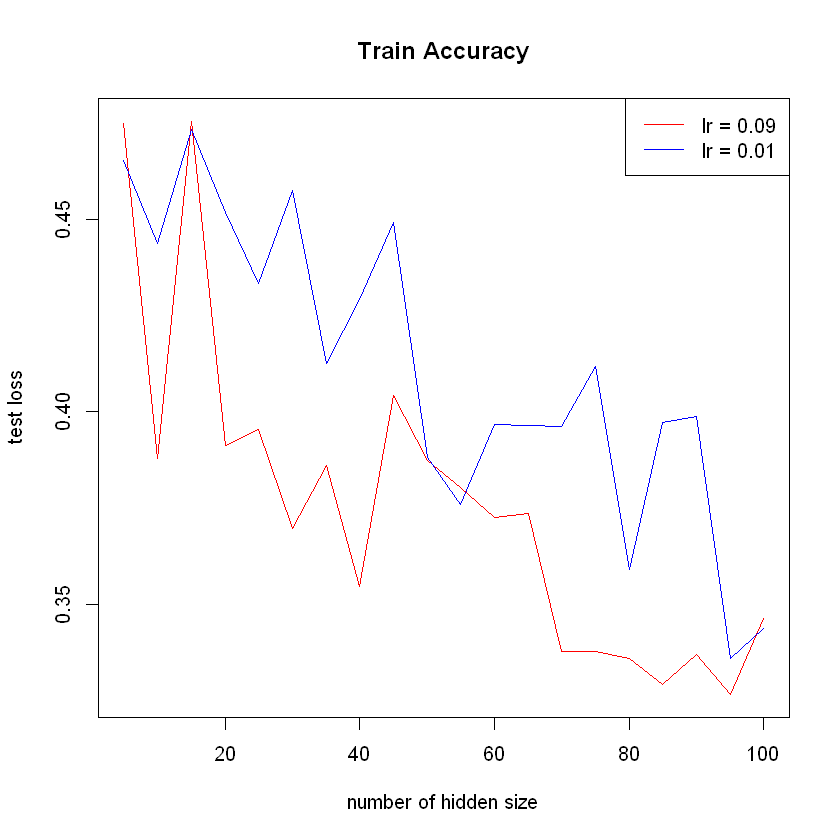

In [222]:
max_ = max(training.result$error, training.result_$error)
min_ = min(training.result$error, training.result_$error)

plot(training.result$k,training.result$error, type = 'l', main='Train Accuracy', ylim =c(min_, max_), col = 'red', ylab = 'test loss', xlab = 'number of hidden size')
lines(training.result_$k,training.result_$error, col = 'blue')
legend('topright',c("lr = 0.09","lr = 0.01"),col=c('red','blue'),lty=c(1,1))

In [230]:
k = which.min(training.result_$error) * 5

In [241]:
W1= training.result_[training.result_$k==k,2][[1]] 
W2 = training.result_[training.result_$k==k,3][[1]] 
b1 = training.result_[training.result_$k==k,4][[1]] 
b2 = training.result_[training.result_$k==k,5][[1]] 

In [242]:
accuracy(prediction(X1, W1, W2, b1, b2), T1)
accuracy(prediction(X2, W1, W2, b1, b2), T2)

[1] 88.76

[1] 89.28

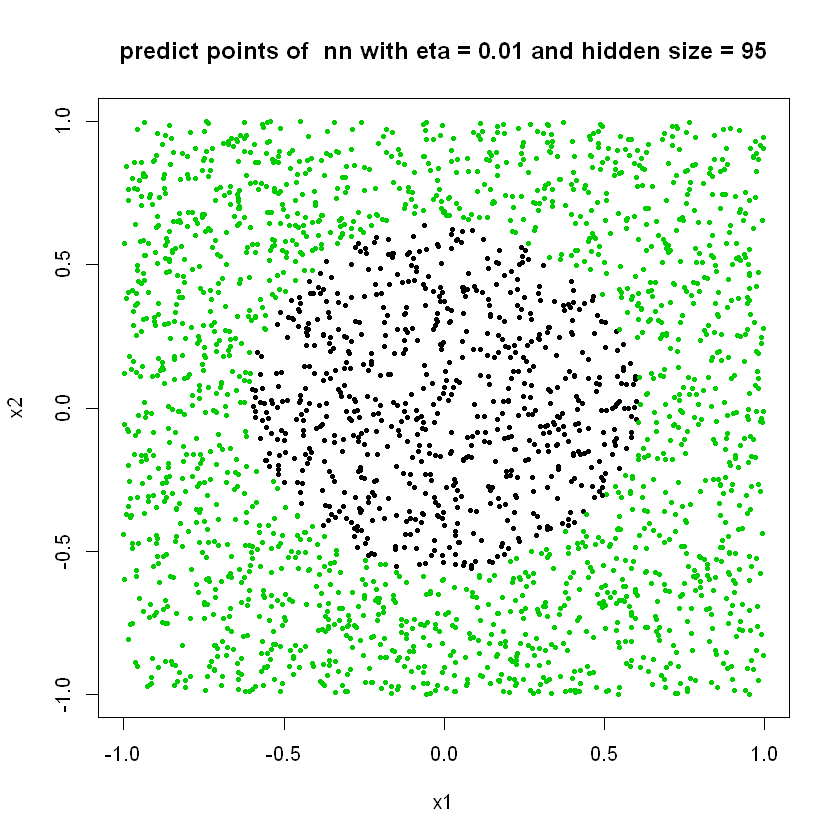

In [244]:
plot(X2[1,], X2[2,], col=adjustcolor(prediction(X2, W1, W2, b1, b2)+2, alpha=1), pch=16, 
            main=paste('predict points of  nn with eta = 0.01 and hidden size =', as.character(k)), xlab = 'x1', ylab = 'x2', cex = 0.5)